In [114]:
try:
    import os
    import glob
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

except ModuleNotFoundError:
    %pip install pandas
    %pip install seaborn

finally:
    import os
    import glob
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
plt.style.use('fivethirtyeight')

In [306]:
ROOT_FOLDER = 'csv'

# Read csv files
- Skipping 9 rows because of header and empty lines of Vitis AI profiler

In [308]:
df = pd.read_csv(os.path.join(ROOT_FOLDER, 'squeezenet_bomb2_nice_100.csv'), skiprows=9)
df.head()

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),Workload(GOP),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s),Unnamed: 10
0,subgraph_SqueezeNet__SqueezeNet_3041,100,DPUCVDX8G_1:batch-1,14.774,34.093,59.423,0.704,20.65,3.257,97.815,NaN
1,vart::TensorBuffer::copy_tensor_buffer,200,CPU,0.023,0.428,23.995,NaN,NaN,NaN,NaN,NaN
2,xir::XrtCu::run,100,CPU,14.765,34.085,59.411,NaN,NaN,NaN,NaN,NaN
3,runSqueezeNet,1,CPU,3567.976,3567.976,3567.976,NaN,NaN,NaN,NaN,NaN


### Extract the response time in milliseconds and aggregate the results

In [107]:
df = df.drop(columns=['Unnamed: 10'])
response_time = df.iloc[-1, :]['Average Time (ms)']
df_performance = df.iloc[0].to_frame().T
df_performance['Response Time (ms)'] = response_time
df_performance.index = ['SqueezeNet_Bomb2_nice_100']
df_performance.head()

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),Workload(GOP),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s),Response Time (ms)
SqueezeNet_Bomb2_nice_100,subgraph_SqueezeNet__SqueezeNet_3041,100,DPUCVDX8G_1:batch-1,14.774,34.093,59.423,0.704,20.65,3.257,97.815,3567.976


### Create summary performance csv with all models and memory bombs

- Write if not exists
- Append if exists

In [108]:
if not os.path.exists('summary_performance.csv'):
    df_performance.to_csv('summary_performance.csv', encoding='utf-8')
else:
    df_performance.to_csv('summary_performance.csv', mode='a', header=False, encoding='utf-8')

# Load summary performance csv

In [238]:
summary_performance = pd.read_csv('summary_performance.csv', index_col=0, encoding='utf-8')
summary_performance.head()

,Kernel Name,Number Of Runs,CU Full Name,Minimum Time (ms),Average Time (ms),Maximum Time (ms),Workload(GOP),DPU Performance(GOP/s),Mem IO(MB),Mem Bandwidth(MB/s),Response Time (ms)
ResNet50_100,subgraph_conv1,100,DPUCVDX8G_1:batch-1,2.117,2.124,2.147,6.985,3287.963,24.501,11810.707,242.955
SqueezeNet_100,subgraph_SqueezeNet__SqueezeNet_3041,100,DPUCVDX8G_1:batch-1,0.675,0.683,0.768,0.704,1031.113,3.257,4884.115,97.864
Age_100,subgraph_quant_block1_conv1,100,DPUCVDX8G_1:batch-1,8.338,8.348,8.364,29.518,3535.937,139.049,17056.243,871.031
Age_Bomb1_100,subgraph_quant_block1_conv1,100,DPUCVDX8G_1:batch-1,8.342,8.348,8.363,29.518,3535.959,139.049,17056.346,871.454
Age_Bomb2_100,subgraph_quant_block1_conv1,100,DPUCVDX8G_1:batch-1,19.615,39.794,71.318,29.518,741.770,139.049,3578.064,4072.023


### Filter the DataFrame for each model type and sort by response time

In [243]:
age_df = summary_performance[summary_performance.index.str.startswith('Age')]
resnet_df = summary_performance[summary_performance.index.str.startswith('ResNet')]
squeezenet_df = summary_performance[summary_performance.index.str.startswith('SqueezeNet')]

age_df = age_df.sort_values(by='Response Time (ms)', ascending=False)
resnet_df = resnet_df.sort_values(by='Response Time (ms)', ascending=False)
squeezenet_df = squeezenet_df.sort_values(by='Response Time (ms)', ascending=False)

### Calculate the slowdown factor

In [256]:
# Age model
isolated_response_time = age_df['Response Time (ms)'].iloc[age_df.index == 'Age_100'].values[0]
age_df['slowdown'] = (abs(age_df['Response Time (ms)'] - isolated_response_time ) / isolated_response_time)

# ResNet model
isolated_response_time = resnet_df['Response Time (ms)'].iloc[resnet_df.index == 'ResNet50_100'].values[0]
resnet_df['slowdown'] = (abs(resnet_df['Response Time (ms)'] - isolated_response_time ) / isolated_response_time)

# SqueezeNet model
isolated_response_time = squeezenet_df['Response Time (ms)'].iloc[squeezenet_df.index == 'SqueezeNet_100'].values[0]
squeezenet_df['slowdown'] = (abs(squeezenet_df['Response Time (ms)'] - isolated_response_time ) / isolated_response_time)

### Merge the DataFrames into a single DataFrame and save to LaTeX table

In [309]:
slowdown_df = pd.concat([age_df, resnet_df, squeezenet_df])
slowdown_df = slowdown_df.reset_index()
slowdown_df = slowdown_df.sort_values(by='index', ascending=True)
slowdown_df = slowdown_df.loc[slowdown_df.slowdown > 0.0]
slowdown_df = slowdown_df.rename(columns={'index': 'Model', 'Number Of Runs': 'Runs', 'slowdown': 'Slowdown'})
slowdown_df.to_csv('summary_slowdown.csv', encoding='utf-8', index=False)
print(slowdown_df[['Model','Runs','Average Time (ms)','DPU Performance(GOP/s)','Slowdown']].to_latex(
    index=False,
    formatters={"name": str.upper},
    float_format="{:.1f}".format,
    caption="Slowdown of each model with respect to the isolated model",
))

\begin{table}
\centering
\caption{Slowdown of each model with respect to the isolated model}
\begin{tabular}{lrrrr}
\toprule
                    Model &  Runs &  Average Time (ms) &  DPU Performance(GOP/s) &  Slowdown \\
\midrule
            Age\_Bomb1\_100 &   100 &                8.3 &                  3536.0 &       0.0 \\
       Age\_Bomb1\_nice\_100 &   100 &                8.3 &                  3536.9 &       0.0 \\
            Age\_Bomb2\_100 &   100 &               39.8 &                   741.8 &       3.7 \\
       Age\_Bomb2\_nice\_100 &   100 &               39.0 &                   757.1 &       3.5 \\
       ResNet50\_Bomb1\_100 &   100 &                2.1 &                  3296.7 &       0.0 \\
  ResNet50\_Bomb1\_nice\_100 &   100 &                2.1 &                  3293.7 &       0.0 \\
       ResNet50\_Bomb2\_100 &   100 &               33.9 &                   206.0 &      14.4 \\
  ResNet50\_Bomb2\_nice\_100 &   100 &               33.2 &                   210

C:\Users\Matte\AppData\Local\Temp\ipykernel_14768\3239027616.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(slowdown_df[['Model','Runs','Average Time (ms)','DPU Performance(GOP/s)','Slowdown']].to_latex(


### Plot the slowdown factor

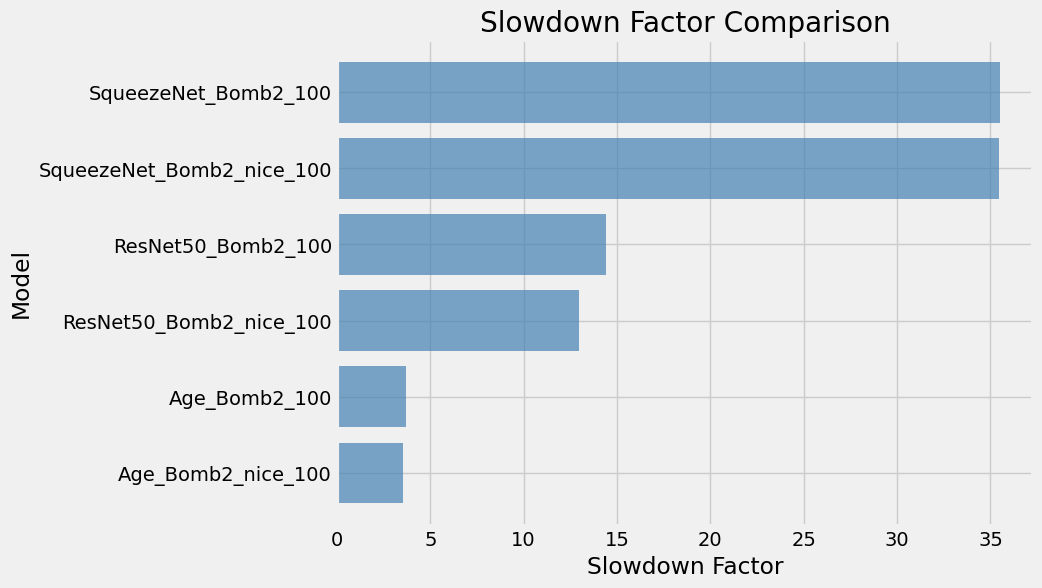

In [305]:
slowdown_df = slowdown_df.sort_values(by='Slowdown', ascending=True)
slowdown_df = slowdown_df.loc[slowdown_df.Slowdown > 0.1]

# Create a horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(
    slowdown_df['Model'], 
    slowdown_df['Slowdown'], 
    color='steelblue',
    linewidth=1,
    alpha=0.7,
    )

# Add labels and title
plt.xlabel('Slowdown Factor')
plt.ylabel('Model')
plt.title('Slowdown Factor Comparison')

# Display the plot
plt.show()

# Model performance comparison

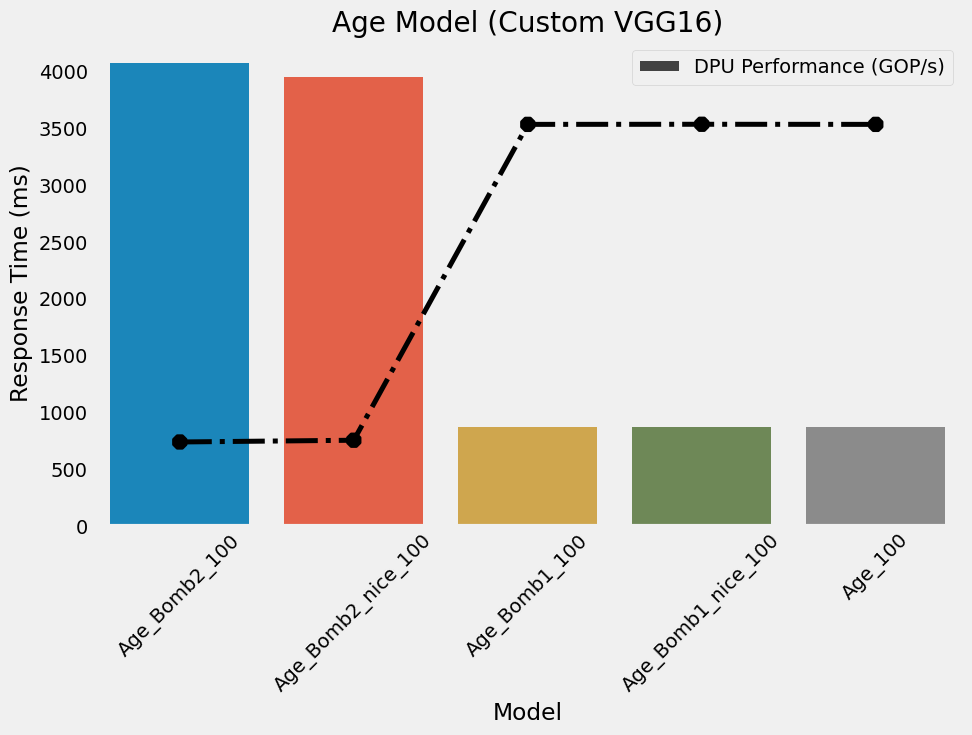

In [237]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot with error bars
ax = sns.barplot(
    data=age_df, 
    x=age_df.index, 
    y='Response Time (ms)', 
    capsize=0.1,
    )

sns.pointplot(
    data=age_df, 
    x=age_df.index, 
    y='DPU Performance(GOP/s)', 
    color='blacK',
    markers='8',
    linestyles = '-.',
    scale=0.5,
    )

# Set plot title and labels
plt.title('Age Model (Custom VGG16)')
plt.xlabel('Model')
plt.ylabel('Response Time (ms)')
plt.xticks(rotation=45)
plt.legend(['DPU Performance (GOP/s)'], loc='upper right')
plt.grid(False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

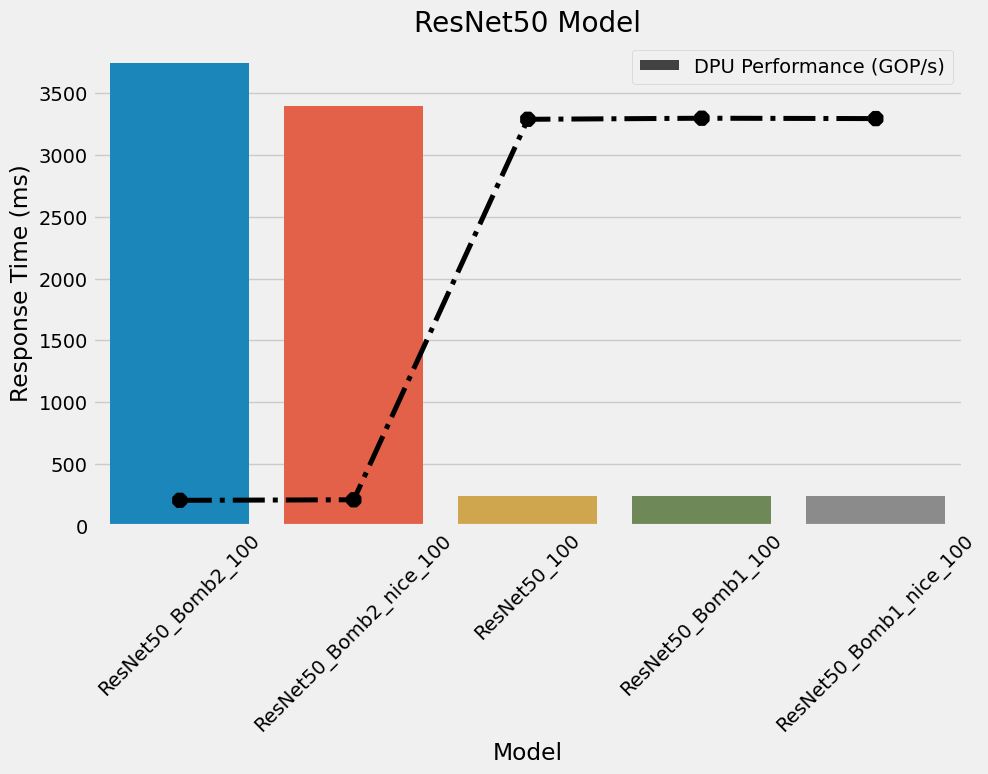

In [208]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot with error bars
sns.barplot(
    data=resnet_df, 
    x=resnet_df.index, 
    y='Response Time (ms)', 
    capsize=0.1,
    )

sns.pointplot(
    data=resnet_df, 
    x=resnet_df.index, 
    y='DPU Performance(GOP/s)', 
    color='blacK',
    markers='8',
    linestyles = '-.',
    scale=0.5,
    )

# Set plot title and labels
plt.title('ResNet50 Model')
plt.xlabel('Model')
plt.ylabel('Response Time (ms)')
plt.xticks(rotation=45)
plt.legend(['DPU Performance (GOP/s)'], loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

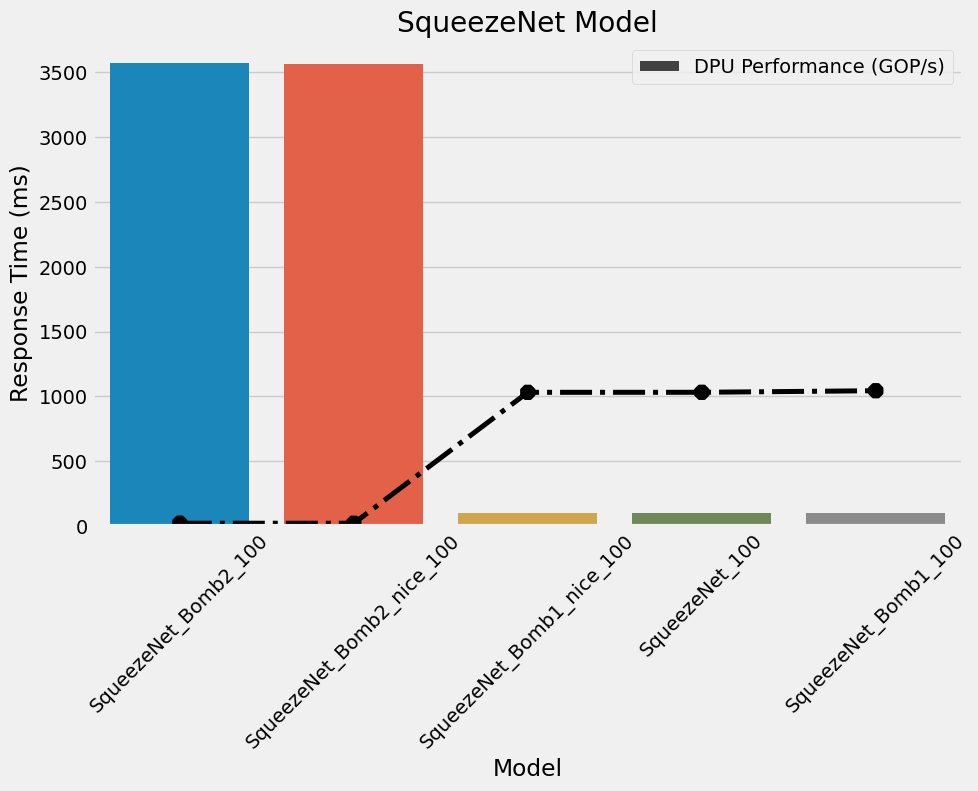

In [209]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot with error bars
sns.barplot(
    data=squeezenet_df, 
    x=squeezenet_df.index, 
    y='Response Time (ms)', 
    capsize=0.1,
    )

sns.pointplot(
    data=squeezenet_df, 
    x=squeezenet_df.index, 
    y='DPU Performance(GOP/s)', 
    color='blacK',
    markers='8',
    linestyles = '-.',
    scale=0.5,
    )

# Set plot title and labels
plt.title('SqueezeNet Model')
plt.xlabel('Model')
plt.ylabel('Response Time (ms)')
plt.xticks(rotation=45)
plt.legend(['DPU Performance (GOP/s)'], loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()